In [58]:
# Imports
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#import tensorflow_decision_forests as tfdf
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import joblib
from joblib import parallel_backend
from sklearn.ensemble import RandomForestRegressor
import sys
import tensorflow as tf
from sklearn.metrics import mean_squared_error

In [2]:
import ray
ray.init(num_cpus=16)
import modin.pandas as pd

2024-02-15 22:55:05,998	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


# Dataset description and source
yadayada

## Dataset import and cleaning

### Possible values for columns
* Entity: Each of the 31 states and one Federal Entity
* Municipality: Each of the municipalities in each of the states or federan entity
* Location: Each of the locations in the municipalities
* Sex: Binary value for male and female
* Age: Age of the participant
* Civil status: Married, Free Union, Separated, Widowed, Divorced, Single
* Religion: Catholic, Christian, Protestant, Atheist, Agnostic, Unknown / Prefer not to say
* Student: If the participant is currently a student
* Degree of education: Maximum degree of education successfully completed. None, Primary school, Started Junior high school, completed junior high school, started high school, completed high school, started college, completed college, higher education, unknown (0)
* Kids with history of substance abuse: If their kids have had history with substance abuse or not. nan for N/A
* Marihuana use: Yes(1), no(2), and prefer not to answer (3)
* Cocaine: Yes(1), no(2), and prefer not to answer (3)
* Crack: Yes(1), no(2), and prefer not to answer (3)
* Hallucinogenic: Yes(1), no(2), and prefer not to answer (3)
* Inhalable: Yes(1), no(2), and prefer not to answer (3)
* Heroine: Yes(1), no(2), and prefer not to answer (3)
* Anfetamines: Yes(1), no(2), and prefer not to answer (3)
* Other: Yes(1), no(2), and prefer not to answer (9)
* Substance age: Age at which the participant started using said substance. Most participants will be NaN, as they have not started using it.
* Perception of the danger of said substance: Whether a subject considers a substance as dangerous or not. 0 means no danger, 1 means some danger, 2 means very dangerous

In [15]:
data = pd.read_csv("ENCODAT_2016_2017.csv")
data = data[["entidad", "munici", "locali", "ds2", "ds3", "ds6", "ds7", "ds8", "ds9", "ds23", 
                "di1a", "di1b", "di1c", "di1d", "di1e", "di1f", "di1g", "di1h", "di4a", "di4b", "di4c", "di4d", 
                "di4e", "di4f", "di4g", "ts18", "ts19", "ts20", "ts21", "ts22", "ts23", 
                "ts24"]]
data.columns = ["entity", "municipality", "location", "Sex", "Age", "civ_status", "religion", "student", "deg_education", "kids_w_abuse_hist", 
                "marihuana", "cocaine", "crack", "hallu", "inhale", "hero", "anfet", "other", "mari_age", "cocaine_age", "crack_age", "hallu_age", 
                "inhale_age", "hero_age", "anfet_age", "mari_danger", "hero_danger", "cocaine_danger", "inha_danger", "anfet_danger", "tobacco_danger", 
                "alcohol_danger"]
# The dataset includes PII for the people that answered the questionnaire, which should be deleted as it is not relevant information
# This dataset also includes several columns that have irrelevant information, which must be deleted
data.head()

,entity,municipality,location,Sex,Age,civ_status,religion,student,deg_education,kids_w_abuse_hist,...,inhale_age,hero_age,anfet_age,mari_danger,hero_danger,cocaine_danger,inha_danger,anfet_danger,tobacco_danger,alcohol_danger
0,1,1,1,1,48,6,6,2,4.0,NaN,...,NaN,NaN,NaN,2,3,3,2,3,3,2
1,1,1,1,2,30,3,1,2,4.0,2.0,...,NaN,NaN,NaN,2,2,2,2,2,2,2
2,1,1,1,1,39,1,1,2,6.0,2.0,...,NaN,NaN,NaN,2,2,2,2,2,2,2
3,1,1,1,2,42,1,1,2,5.0,2.0,...,NaN,NaN,NaN,3,3,3,3,3,2,2
4,1,1,1,2,47,1,4,2,4.0,2.0,...,NaN,NaN,NaN,3,3,3,3,3,3,3


In [16]:
# Drop participants that did not answer their education level, as it may be a relevant column
data = data.dropna(subset = ["deg_education"])
# Drop participants that say that they started abusing substances at age 70 or above, as those are probably false
data = data.drop((data[data["mari_age"] > 70]).index)
data = data.drop((data[data["cocaine_age"] > 70]).index)
data = data.drop((data[data["crack_age"] > 70]).index)
data = data.drop((data[data["hallu_age"] > 70]).index)
data = data.drop((data[data["inhale_age"] > 70]).index)
data = data.drop((data[data["hero_age"] > 70]).index)
data = data.drop((data[data["anfet_age"] > 70]).index)
# Columns entity, municipality, and location need to be merged, as otherwise, the model may associate the location and municipality individually
# from the entity, which should not be the case, as the 3 values are related
data["residence"] = data[data.columns[0:3]].apply(lambda z: ''.join(z.dropna().astype(str)),axis=1)
data["entity"] = data["residence"]
data = data.drop(["municipality", "location", "residence"], axis=1)
data = data.rename(columns={"entity":"residence"})
data["residence"] = data["residence"].astype("int64")
# In education degree, 99 is used as an unknown value. However, to make this more consistent, it will be changed to 0
data[data["deg_education"] == 99] == 0
data

,residence,Sex,Age,civ_status,religion,student,deg_education,kids_w_abuse_hist,marihuana,cocaine,...,inhale_age,hero_age,anfet_age,mari_danger,hero_danger,cocaine_danger,inha_danger,anfet_danger,tobacco_danger,alcohol_danger
0,111,1,48,6,6,2,4.0,NaN,2,2,...,NaN,NaN,NaN,2,3,3,2,3,3,2
1,111,2,30,3,1,2,4.0,2.0,2,2,...,NaN,NaN,NaN,2,2,2,2,2,2,2
2,111,1,39,1,1,2,6.0,2.0,2,2,...,NaN,NaN,NaN,2,2,2,2,2,2,2
3,111,2,42,1,1,2,5.0,2.0,2,2,...,NaN,NaN,NaN,3,3,3,3,3,2,2
4,111,2,47,1,4,2,4.0,2.0,2,2,...,NaN,NaN,NaN,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56872,3256158,2,40,1,1,2,5.0,2.0,2,2,...,NaN,NaN,NaN,3,3,3,3,3,3,2
56873,3256158,1,17,6,1,3,5.0,NaN,2,2,...,NaN,NaN,NaN,3,3,3,3,3,2,3
56874,3256158,2,54,2,1,2,2.0,1.0,2,2,...,NaN,NaN,NaN,2,3,3,3,3,3,2
56875,3256158,1,15,6,1,2,3.0,NaN,1,2,...,NaN,NaN,NaN,2,2,3,3,3,3,3


### Creating two datasets
There are two things that need to be predicted: 
* whether someone will become addicted to substances
* if they do become addicted, at which age will they become addicted

For this reason, there is a need for two datasets: 
* One without the ages at which the subject becomes addicted, as it is still not known if they will or not become addicted, and the substances do not matter, as much as if they become addicted or not
* One that includes the substance to which they became addicted, as well as the ages so it is able to predict the ages for future substance abusers

In [17]:
# The original data is saved, so it can be recovered if needed
data_orig = data.copy()
# A new dataset is created to predict whether someone will become addicted or not. The exact substance is irrelevant for purposes of this project
data_abuse = data.copy()

In [18]:
data_abuse = data_abuse.drop(["mari_age",'cocaine_age', 'crack_age', 'hallu_age','inhale_age', 'hero_age', 'anfet_age'], axis=1)
# Now the columns in which the subjects mention if they have used a substance are used to create an output variable called [abuse]

In [19]:
# There are 3 possible answers for whether a subject uses a substance or not: yes, no, prefer not to answer.
# For this project, yes and prefer not to answer will be considered the same, as most people, when they answer that they would prefer not to answer, 
# the answer is yes
data_abuse["abuse"] = np.where(
    (data_abuse["marihuana"] == 1) | (data_abuse["cocaine"] == 1) | (data_abuse["crack"] == 1) | (data_abuse["hallu"] == 1) 
    | (data_abuse["inhale"] == 1) | (data_abuse["hero"] == 1) | (data_abuse["anfet"] == 1) | (data_abuse["other"] == 1) 
    | (data_abuse["marihuana"] == 9) | (data_abuse["cocaine"] == 9) | (data_abuse["crack"] == 9) | (data_abuse["hallu"] == 9) 
    | (data_abuse["inhale"] == 9) | (data_abuse["hero"] == 9) | (data_abuse["anfet"] == 9) | (data_abuse["other"] == 9)
, 1, 0)
# Now the individual columns can be deleted
data_abuse = data_abuse.drop(["marihuana", "cocaine", "crack", "hallu", "inhale", "hero", "anfet", "other"], axis = 1)
data_abuse

,residence,Sex,Age,civ_status,religion,student,deg_education,kids_w_abuse_hist,mari_danger,hero_danger,cocaine_danger,inha_danger,anfet_danger,tobacco_danger,alcohol_danger,abuse
0,111,1,48,6,6,2,4.0,NaN,2,3,3,2,3,3,2,0
1,111,2,30,3,1,2,4.0,2.0,2,2,2,2,2,2,2,0
2,111,1,39,1,1,2,6.0,2.0,2,2,2,2,2,2,2,0
3,111,2,42,1,1,2,5.0,2.0,3,3,3,3,3,2,2,0
4,111,2,47,1,4,2,4.0,2.0,3,3,3,3,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56872,3256158,2,40,1,1,2,5.0,2.0,3,3,3,3,3,3,2,0
56873,3256158,1,17,6,1,3,5.0,NaN,3,3,3,3,3,2,3,0
56874,3256158,2,54,2,1,2,2.0,1.0,2,3,3,3,3,3,2,0
56875,3256158,1,15,6,1,2,3.0,NaN,2,2,3,3,3,3,3,1


In [20]:
# Another dataset is created, but using only those subjects that are actually addicted, to be able to predict the age at which they will become addicted
data_age = data[data_abuse["abuse"] == 1].copy()
data_age = data_age.drop(["marihuana", "cocaine", "crack", "hallu", "inhale", "hero", "anfet", "other"], axis = 1)
# A new column is created called [started], which is only the first age in the ages columns, which is the age at which they started using substances
data_age["started"] = data_age[["mari_age",'cocaine_age', 'crack_age', 'hallu_age','inhale_age', 'hero_age', 'anfet_age']].min(axis=1)
# Finally, the columns for ages are dropped, as otherwise, the model would just learn to use the minimum age as the output
data_age = data_age.drop(["mari_age",'cocaine_age', 'crack_age', 'hallu_age','inhale_age', 'hero_age', 'anfet_age'], axis = 1)
data_age

,residence,Sex,Age,civ_status,religion,student,deg_education,kids_w_abuse_hist,mari_danger,hero_danger,cocaine_danger,inha_danger,anfet_danger,tobacco_danger,alcohol_danger,started
19,111,1,53,4,1,2,4.0,NaN,3,3,3,3,3,2,2,23.0
25,111,2,59,4,1,2,9.0,1.0,3,3,3,3,3,2,3,55.0
27,111,2,53,5,6,2,9.0,2.0,1,3,3,3,2,1,2,25.0
47,111,2,31,6,1,2,8.0,NaN,1,3,3,3,3,3,2,22.0
57,111,1,46,3,4,2,4.0,2.0,2,3,3,3,3,2,2,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56820,32561,2,17,6,1,3,5.0,NaN,2,2,2,3,2,2,3,14.0
56821,32561,1,41,1,1,2,1.0,NaN,2,3,3,3,3,2,2,15.0
56832,32561,1,27,3,1,2,4.0,2.0,2,2,2,3,3,2,1,18.0
56863,3256158,1,26,3,1,2,4.0,2.0,1,2,2,3,3,2,2,12.0


In [21]:
# Saving the processed datasets to avoid executing the same code in future instances
data_abuse.to_csv("data_abuse.csv", index=False)
data_age.to_csv("data_age.csv", index=False)

In [3]:
data_abuse = pd.read_csv("data_abuse.csv")

In [39]:
data_age = pd.read_csv("data_age.csv")

## Exploration
yada

In [ ]:
data_abuse.drop(["residence", "Sex", "civ_status", "religion", "student", "kids_w_abuse_hist"],axis=1).describe().T

It can be seen that the mean age of the participants is 33 years, with the youngest participants being 12, and the oldest participants being 65. 
An important detail that can be obtained from this data is that the average perception of dange for each of the drugs is over 2, which means that the majority of the participants labeled the drugs as dangerous or highly dangerous. 
It can also be seen that the mean degree of education of the participants indicates that most of them completed junior high school, but no more. 
This is consistent with the average person in rural Mexico.  
Finally, as the abuse column shows a very low mean, this tells us that the vast majority of participants did not admit to abusing substances. 

In [ ]:
data_age[["Age", "deg_education", "started"]].describe().T

It can be seen in the statistics for the data_age dataset that the average age for subjects to start abusing certain substances is between 17 and 20, which is the common age at which people in Mexico start assisting college. College is an environment where people from all backgrounds get together, and it is not uncommon for people to do things they would normally not do in order to fit in, which includes using substances they would normally not use.  
Another interesting thing to note is that the average education grade is higher that the dataset that includes people that abuse substances and those that do not. Unfortunately, this does not really tells us anything about the education average, as it may be due to the value for unknown degree, which is simply the highest value, 99

## Visualization
ddfdf

### Full dataset

In [11]:
data_abuse.dtypes

residence              int64
Sex                    int64
Age                    int64
civ_status             int64
religion               int64
student                int64
deg_education        float64
kids_w_abuse_hist    float64
mari_danger            int64
hero_danger            int64
cocaine_danger         int64
inha_danger            int64
anfet_danger           int64
tobacco_danger         int64
alcohol_danger         int64
abuse                  int64
dtype: object

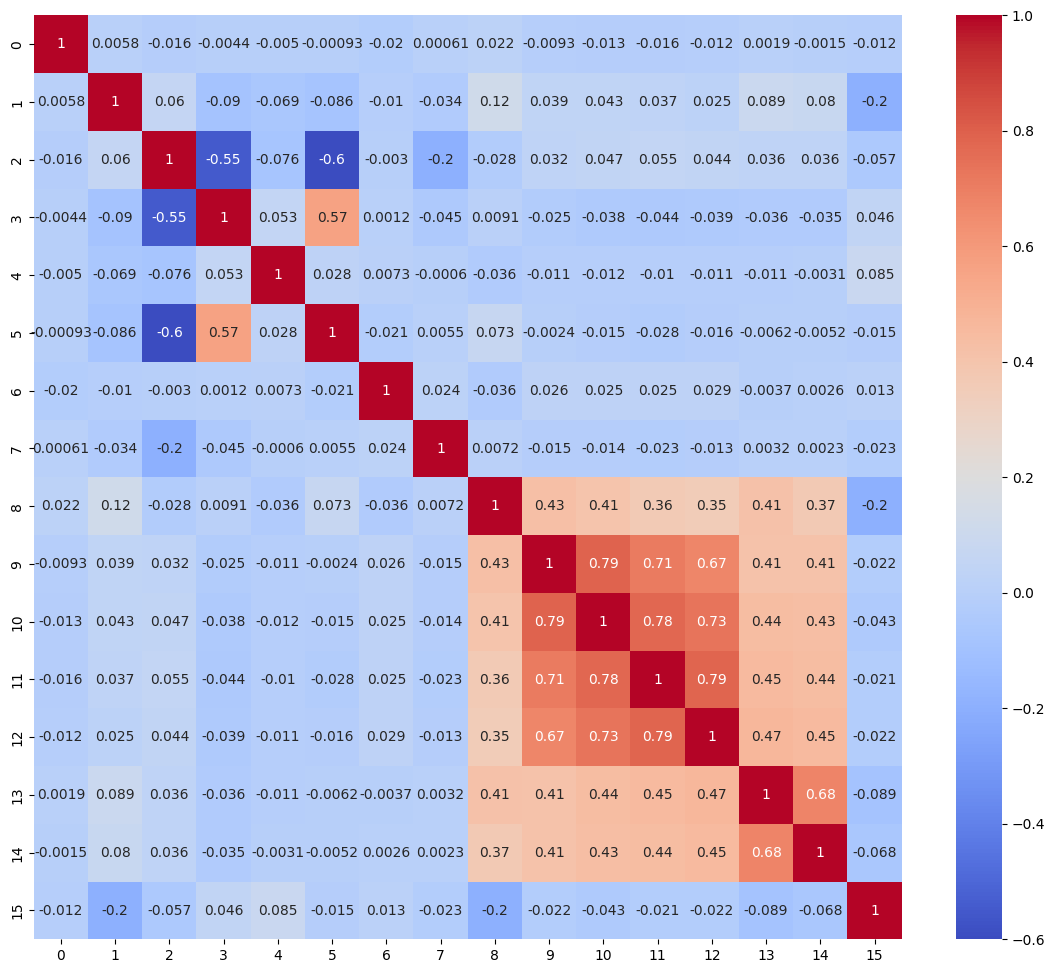

In [12]:
corr = data_abuse.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

It can be seen that the target variable, target, does not have a strong correlation with any other variable.  
This may cause issues, as simple models may not find good enough relations to be able to predict if a subject will be addicted. 

<Axes: ylabel='Count'>

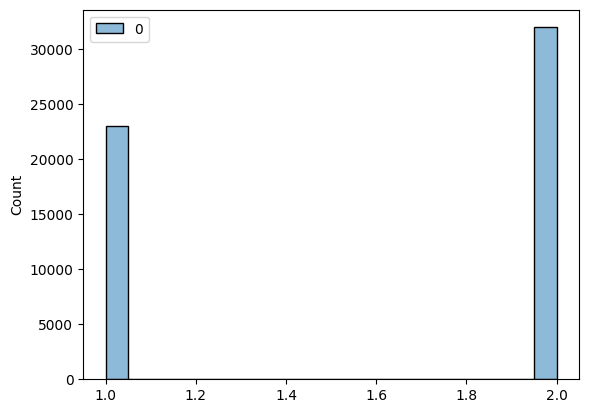

In [13]:
sns.histplot(data_abuse[["Sex"]])

Most of the subjects that answered the survey are female. This will prove interesting in the next section.

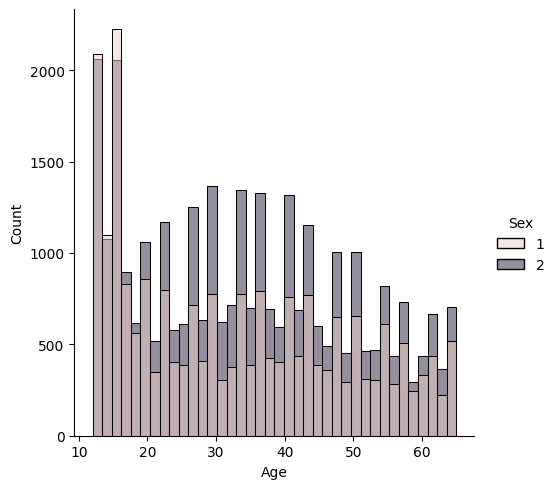

In [14]:
sns.displot(data = data_abuse, x = "Age", hue = "Sex")

This plot shows us that the interrogated subjects age follows a normal distribution, with the exception between ages 12 and 20. 

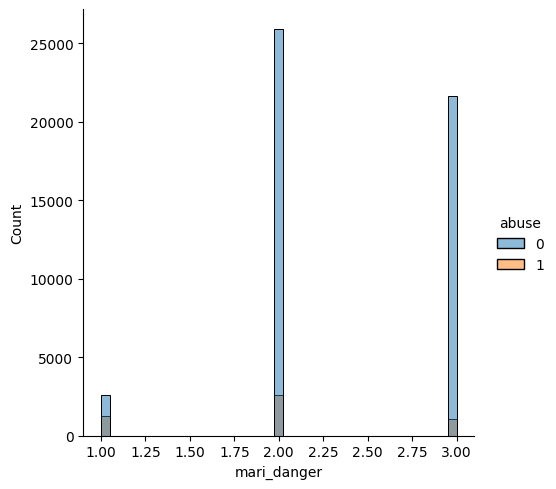

In [15]:
sns.displot(data = data_abuse, x = "mari_danger", hue = "abuse")

It is also interesting to see that most of the people that answered that substances such as marihuana are dangerous, are subjects that do not abuse any substances, while those that answered as no, half of them use substances.  

### Confirmed addicted dataset

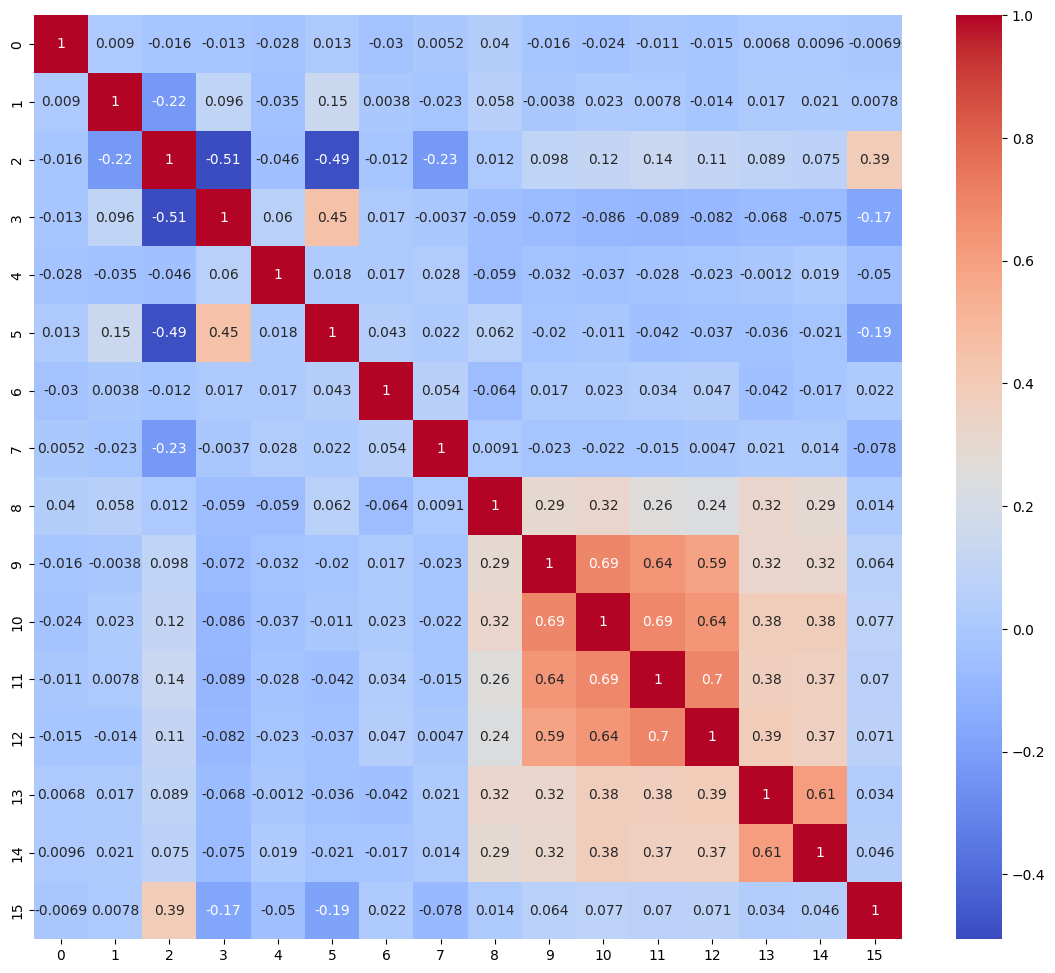

In [16]:
corr = data_age.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

It can be seen that the only column with a relative high correlation is column number 3, which would be Age.  
This reinforces the idea that an age between 17 and 20 has a high relationship with the use of substances. 

<Axes: ylabel='Count'>

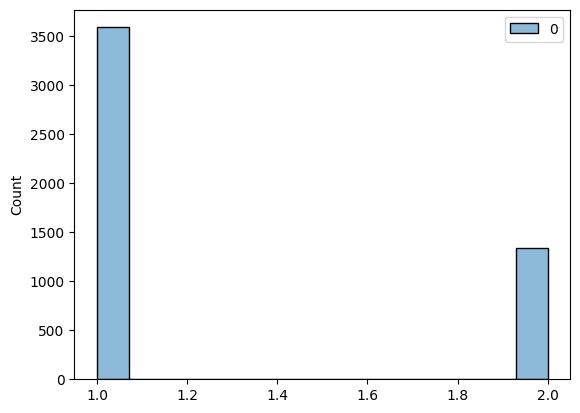

In [17]:
sns.histplot(data=data_age[["Sex"]])

This histogram shows that the vast majority of those subjects that admitted using substances were male, which is a high contrast to the original dataset, where most of the participants where female.  

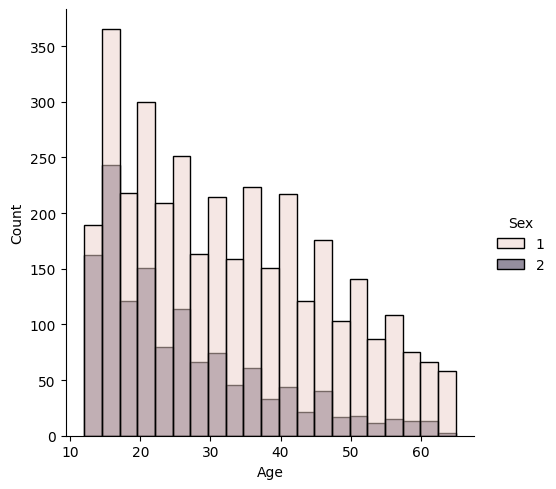

In [18]:
sns.displot(data = data_age, x = "Age", hue = "Sex")

Another difference compared to the original, or complete, dataset, is that the ages are in a decreasing order, where most of the participants that admited to abusing substances are young, and the higher the age, fewer participants answered positively. Also, males are the largest group in all the age groups. 

# Model training
reason for model ya know

## Random Forest

In [8]:
data_age.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 4939 entries, 0 to 4938
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   residence          4939 non-null   int64  
 1   Sex                4939 non-null   int64  
 2   Age                4939 non-null   int64  
 3   civ_status         4939 non-null   int64  
 4   religion           4939 non-null   int64  
 5   student            4939 non-null   int64  
 6   deg_education      4939 non-null   float64
 7   kids_w_abuse_hist  2263 non-null   float64
 8   mari_danger        4939 non-null   int64  
 9   hero_danger        4939 non-null   int64  
 10  cocaine_danger     4939 non-null   int64  
 11  inha_danger        4939 non-null   int64  
 12  anfet_danger       4939 non-null   int64  
 13  tobacco_danger     4939 non-null   int64  
 14  alcohol_danger     4939 non-null   int64  
 15  started            4367 non-null   float64
dtypes: float64(3), int6

It can be seen that the variable Started has null values, which the model for Random Forest cannot use.  
Therefore, these null values will be filled with -1, indicating a value that cannot be. 

In [40]:
data_age["started"] = data_age["started"].fillna(-1)
data_age.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 4939 entries, 0 to 4938
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   residence          4939 non-null   int64  
 1   Sex                4939 non-null   int64  
 2   Age                4939 non-null   int64  
 3   civ_status         4939 non-null   int64  
 4   religion           4939 non-null   int64  
 5   student            4939 non-null   int64  
 6   deg_education      4939 non-null   float64
 7   kids_w_abuse_hist  2263 non-null   float64
 8   mari_danger        4939 non-null   int64  
 9   hero_danger        4939 non-null   int64  
 10  cocaine_danger     4939 non-null   int64  
 11  inha_danger        4939 non-null   int64  
 12  anfet_danger       4939 non-null   int64  
 13  tobacco_danger     4939 non-null   int64  
 14  alcohol_danger     4939 non-null   int64  
 15  started            4939 non-null   float64
dtypes: float64(3), int6

Something similar with the input variable for kids w abuse history

In [41]:
data_age["kids_w_abuse_hist"] = data_age["kids_w_abuse_hist"].fillna(0)
data_age.info()

<class 'modin.pandas.dataframe.DataFrame'>
RangeIndex: 4939 entries, 0 to 4938
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   residence          4939 non-null   int64  
 1   Sex                4939 non-null   int64  
 2   Age                4939 non-null   int64  
 3   civ_status         4939 non-null   int64  
 4   religion           4939 non-null   int64  
 5   student            4939 non-null   int64  
 6   deg_education      4939 non-null   float64
 7   kids_w_abuse_hist  4939 non-null   float64
 8   mari_danger        4939 non-null   int64  
 9   hero_danger        4939 non-null   int64  
 10  cocaine_danger     4939 non-null   int64  
 11  inha_danger        4939 non-null   int64  
 12  anfet_danger       4939 non-null   int64  
 13  tobacco_danger     4939 non-null   int64  
 14  alcohol_danger     4939 non-null   int64  
 15  started            4939 non-null   float64
dtypes: float64(3), int6

### Data split

In [42]:
data_age = data_age.sample(frac = 1)
X = data_age.drop(["started"], axis=1).copy()
y = data_age["started"].copy()
# Splits the dataset into training and testing with a 70:30 split ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(0.3), random_state=42)
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (3457, 15)
X_test shape: (1482, 15)
y_train shape: (3457,)
y_test shape: (1482,)


### Model creation and evaluation

In [43]:
random_forest = RandomForestRegressor(max_depth=10, random_state=0)
random_forest.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=0)

In [44]:
predicted = random_forest.predict(X_test)

In [45]:
mean_squared_error(y_test, predicted)

49.084997989187976

In [46]:
comparison_dataset = pd.DataFrame(data = [y_test, predicted]).T
comparison_dataset.columns = ["Y", "Predicted"]
comparison_dataset

,Y,Predicted
4769,45.0,NaN
2998,19.0,NaN
1481,-1.0,17.043601
141,35.0,16.916053
3851,13.0,NaN
...,...,...
1618,18.0,NaN
1887,15.0,NaN
1483,18.0,NaN
3674,15.0,NaN


In [52]:
comparison_dataset = comparison_dataset.dropna()

In [53]:
comparison_dataset

,Y,Predicted
1481,-1.0,17.043601
141,35.0,16.916053
1410,18.0,17.030771
1459,14.0,19.804143
635,18.0,19.653451
...,...,...
1368,16.0,18.434759
1161,15.0,18.400963
129,22.0,16.841323
647,12.0,17.553886


Unfortunately, it can be seen that, although the mean square error is relatively low, the reason is that the comparison is being done with a large number of NaN values.  
After removing the NaN values in the predicted column, it can be seen that the Random Forest model returns most of the predictions between 16 and 19. This could be a good average age at which participants started using drugs, but it is not a good model, as it does not correctly generalize.

It can be seen that the best parameter for this model is a maximum depth of 18.  
Although the correctly predicted samples increased from just over 700 to over 800, the number is still too low compared to the total >5000.  
Therefore, Random Forest may not be the best model for predicting if a subject will be addicted to a substance.  

### variable cleaning

In [54]:
del(predicted)
del(comparison_dataset)

## SVM

In [55]:
data_age.info()

<class 'modin.pandas.dataframe.DataFrame'>
Index: 4939 entries, 492 to 355
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   residence          4939 non-null   int64  
 1   Sex                4939 non-null   int64  
 2   Age                4939 non-null   int64  
 3   civ_status         4939 non-null   int64  
 4   religion           4939 non-null   int64  
 5   student            4939 non-null   int64  
 6   deg_education      4939 non-null   float64
 7   kids_w_abuse_hist  4939 non-null   float64
 8   mari_danger        4939 non-null   int64  
 9   hero_danger        4939 non-null   int64  
 10  cocaine_danger     4939 non-null   int64  
 11  inha_danger        4939 non-null   int64  
 12  anfet_danger       4939 non-null   int64  
 13  tobacco_danger     4939 non-null   int64  
 14  alcohol_danger     4939 non-null   int64  
 15  started            4939 non-null   float64
dtypes: float64(3), int64(13

### Data split

In [57]:
# Prepare the X and y from the dataset
# Randomize the dataset
data_age = data_age.sample(frac = 1)
X = data_age.drop(["started"], axis=1).copy()
y = data_age["started"].copy()
# Splits the dataset into training and testing with a 70:30 split ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(0.3), random_state=42)

### Model training

In [59]:
svm_model = SVR()
svm_model.fit(X_train, y_train)
svm_model

SVR()

In [60]:
predicted = svm_model.predict(X_test)

In [62]:
mean_squared_error(y_test, predicted)

55.03620992050928

In [64]:
comparison_dataset = pd.DataFrame(data = [y_test, predicted]).T
comparison_dataset.columns = ["Y", "Predicted"]
comparison_dataset

,Y,Predicted
169,16.0,16.096186
857,11.0,16.085545
360,19.0,16.081521
2832,24.0,NaN
470,15.0,16.099732
...,...,...
276,23.0,16.099453
1735,14.0,NaN
1572,20.0,NaN
3657,-1.0,NaN


In [65]:
comparison_dataset = comparison_dataset.dropna()
comparison_dataset

,Y,Predicted
169,16.0,16.096186
857,11.0,16.085545
360,19.0,16.081521
470,15.0,16.099732
1400,14.0,16.099911
...,...,...
1179,23.0,16.100025
335,16.0,16.100059
266,32.0,16.100115
750,19.0,16.099740


### Model selection

In [66]:
#Hyperparamter tuning using Gridsearch
svm_model = SVR()
param_grid = {'C': [1, 5],
              "degree" : [3,5,7]}
grid = GridSearchCV(svm_model,param_grid, verbose=10)

In [67]:
with parallel_backend('threading'):
    grid.fit(X_train,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START C=1, degree=3...............................................
[CV 2/5; 1/6] START C=1, degree=3...............................................
[CV 3/5; 1/6] START C=1, degree=3...............................................
[CV 4/5; 1/6] START C=1, degree=3...............................................
[CV 5/5; 1/6] START C=1, degree=3...............................................
[CV 1/5; 2/6] START C=1, degree=5...............................................
[CV 2/5; 2/6] START C=1, degree=5...............................................
[CV 3/5; 2/6] START C=1, degree=5...............................................
[CV 4/5; 2/6] START C=1, degree=5...............................................
[CV 5/5; 2/6] START C=1, degree=5...............................................
[CV 1/5; 3/6] START C=1, degree=7...............................................
[CV 2/5; 3/6] START C=1, degree=7................

(raylet) [2024-02-16 00:05:06,000 E 13512 13512] (raylet) node_manager.cc:3022: 1 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: 31ea635ffdf57bb0db5f0e2c5b99aa2c24121b6f24847b650cc040b3, IP: 172.17.165.96) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.17.165.96`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.


In [68]:
# It can be seen that the best parameters for the model are:
grid.best_params_

{'C': 1, 'degree': 3}

Unfortunately, the results for the best estimator are equal to the default estimator, which has already been demonstrated to not be a good model for predicting the age at which a person will start using substances. 